# Figure 3: Model of the growth dynamics in the absence of treatment

In [31]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [32]:
# Data and solver configurations
cellLine = "OVCAR3"
modelList = ["Exponential", "Logistic", "Gompertz", "vonBertalanffy", "GeneralisedLogistic"]
runFitting = True
n_bootstraps = 250 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
# Due to the random perturbations during bootstrapping the ODE solver can fail whilst fitting 
# to the synthetic data. To fix this, use more stringent solver arguments
solver_kws_bootstrapping = solver_kws.copy()
solver_kws_bootstrapping['max_step'] = 0.5

# Parameters to fit
params = Parameters()
params.add('r', value=0.05, min=1e-4, max=2., vary=True)
params.add('v', value=1, min=0, max=5, vary=True)
params.add('K', value=100., min=0, max=100., vary=True)
params.add('N0', value=10, min=0, max=100., vary=False)
params.add('DMax', value=100, vary=False)
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':0}

# Environment
nProcesses = 4 # Number of cores to use for bootstrapping
dataDir = "./data/"
modelDir = "./fits/growthModel/"
modelPalette = {"Exponential":sns.xkcd_rgb["grey"], "Logistic":sns.xkcd_rgb["clear blue"], 
                "Gompertz":sns.xkcd_rgb["merlot"], "vonBertalanffy":sns.xkcd_rgb["topaz"],
                "GeneralisedLogistic":sns.xkcd_rgb["mango"]}

In [33]:
# Load off-treatment data
dataDf_all = pd.read_csv("./data/continuousTreatmentDf_cleaned.csv",index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DrugConcentration==0)]

## b) Fit and compare growth models using data from cells grown in untreated conditions

### Carry out fitting

In [7]:
# Prepare data
trainingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
trainingData = trainingData.groupby(by="Time").mean()
trainingData.reset_index(inplace=True)

if runFitting:
    for modelName in tqdm(modelList):
        # Setup env
        currOutDir = os.path.join(modelDir,cellLine,modelName)
        utils.mkdir(currOutDir)
        tmpModel = MakeModelFromStr(modelName)
        currParams = Parameters()
        currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
        if params['N0'].vary==False: params['N0'].value = trainingData.Confluence.iloc[0]

        # Fit
        fitObj = minimize(residual, currParams, args=(0, trainingData, tmpModel, "Confluence", solver_kws),**optimiser_kws)
        fitObj.fitId = 0
        fitObj.modelName = modelName
        fitObj.data = trainingData
        fitObj.rSq = ComputeRSquared(fitObj,trainingData)

        # Post-process
        pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [8]:
if runFitting:
    # Use multi-threading to speed up computation
    pool = mp.Pool(processes=nProcesses)
    def bootstrapJob(job):
        fitObj, outName = job
        return perform_bootstrap(fitObj, n_bootstraps=n_bootstraps, show_progress=False,
                                    solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws, outName=outName)
    jobList = []
    for modelName in modelList:
        outDir = os.path.join(modelDir,cellLine,modelName)
        fitObj,_ = LoadFit(modelName,fitDir=outDir)
        jobList.append([fitObj,os.path.join(outDir, "bootstraps.csv")])
    # [bootstrapJob(x) for x in jobList]
    list(tqdm(pool.imap(bootstrapJob, jobList), total=len(jobList)));

100%|██████████| 5/5 [02:24<00:00, 28.87s/it]


### Plot fits

100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


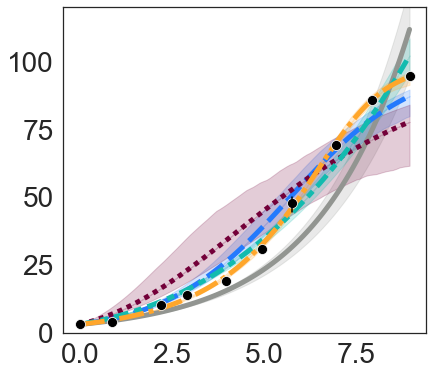

In [9]:
outDir = os.path.join(modelDir,cellLine)
currData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="lowDensity")]
# Load models and simulate
tmpList = []
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                             treatmentScheduleList=utils.ExtractTreatmentFromDf(currData),
                                                             show_progress = False, n_time_steps=100,
                                                             alpha=ci_significanceLevel,
                                                             solver_kws=solver_kws_bootstrapping, optimiser_kws=optimiser_kws)
    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelFitsDf = pd.concat(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
             lw=5,palette=modelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for modelName in modelList:
    currPredictionDf = modelFitsDf[modelFitsDf.Model==modelName]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=currData,ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,120)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_growthModel_%s.pdf"%cellLine)

### Plot inferred density-dependence relationship

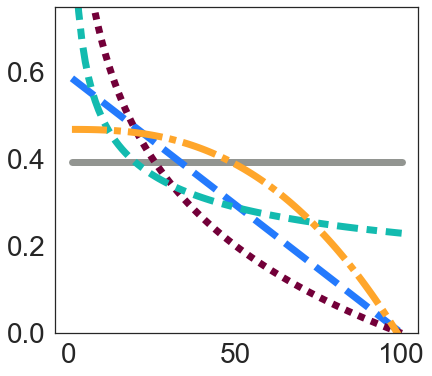

In [10]:
xVec = np.linspace(1,100,100)
# 1. Compute the per-capita growth rate under each model (using the estimated parameters)
outDir = os.path.join(modelDir,cellLine)
tmpDfList = []
for modelName in modelList:
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir, modelName))
    perCapitaGrowthRateList = [myModel.ModelEqns(None,[x,0])[0]/x for x in xVec]
    tmpDf = pd.DataFrame({"Model":modelName, "Density":xVec, 
                          "PerCapitaGrowthRate":perCapitaGrowthRateList})
    tmpDfList.append(tmpDf)
growthRateDf = pd.concat(tmpDfList)

# 2. Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Density",y="PerCapitaGrowthRate", hue="Model", style="Model",
                 lw=7,palette=modelPalette,
                 legend=False,
                 data=growthRateDf, ax=ax)
ax.set_ylim(0,0.75)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/densityDependence_%s.pdf"%cellLine)

### Quantify goodness-of-fit using AIC

100%|██████████| 5/5 [00:00<00:00, 582.28it/s]


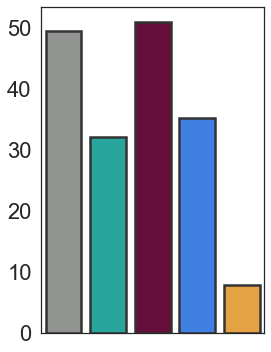

In [11]:
measure = "AIC"
outDir = os.path.join(modelDir,cellLine)
tmpList = []
for modelName in tqdm(modelList):
    fitObj,_ = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))
    tmpList.append({"Model":modelName, "FitId":fitObj.fitId,
                    "r2":fitObj.rSq, "AIC":fitObj.aic, "BIC":fitObj.bic})
comparisonDf_gof = pd.DataFrame(tmpList)

# Plot
fig, ax = plt.subplots(1,1,figsize=(4,6))
comparisonDf_gof.sort_values(by=measure,inplace=True)
sns.barplot(x="Model",y=measure,
            edgecolor=".2",linewidth=2.5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=comparisonDf_gof, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.savefig("./figures/%s_fit_%s.pdf"%(measure,cellLine))

## c) Test model by benchmarking its ability to predict growth from higher initial seeding density

### Generate predictions

In [12]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currPredictionDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf),
                                                     initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                     show_progress=False, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_bootstrapping)

    currPredictionDf.rename(columns={"Estimate_MLE":"TumourSize"}, inplace=True)
    currPredictionDf['Model'] = modelName
    currPredictionDf['CellLine'] = cellLine
    tmpList.append(currPredictionDf.copy())
modelPredictionDf = pd.concat(tmpList)

100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


### Plot predictions

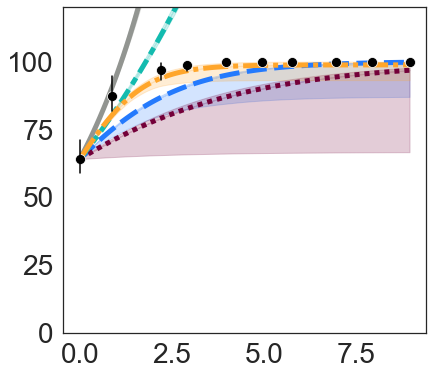

In [13]:
# Plot Predictions
outDir = os.path.join(modelDir,cellLine)
testingData = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]

# Plot
fig, ax = plt.subplots(1,1,figsize=(6.5,6))
sns.lineplot(x="Time",y="TumourSize", hue="Model", style="Model",
         lw=5,palette=modelPalette,
         legend=False,
         data=modelPredictionDf[modelPredictionDf.CellLine==cellLine], ax=ax)
for modelName in modelList:
    currPredictionDf = modelPredictionDf[(modelPredictionDf.CellLine==cellLine) & 
                                         (modelPredictionDf.Model==modelName)]
    plt.fill_between(currPredictionDf.Time, currPredictionDf['CI_Lower_Bound'], 
                     currPredictionDf['CI_Upper_Bound'], color=modelPalette[modelName], alpha=0.2)

sns.lineplot(x="Time",y="Confluence",style="CellLine",err_style='bars', #units="ReplicateId", estimator=None,
         markers="o", lw=0, markersize=10, color="black",
         legend=False,
        data=testingData,ax=ax)
ax.set_ylim(0,120)
ax.tick_params(labelsize=28)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_growthModel_%s.pdf"%cellLine)

### Quantify goodness-of-fit of the predictions

In [14]:
# Run predictions
tmpList = []
outDir = os.path.join(modelDir,cellLine)
testingDataDf = dataDf_all[(dataDf_all.CellLine==cellLine) & (dataDf_all.SeedingDensity=="highDensity")]
testingDataDf = testingDataDf.groupby(by="Time").mean()
testingDataDf.reset_index(inplace=True)

# Load models and simulate
for modelName in tqdm(modelList):
    fitObj,myModel = LoadFit(modelName,fitDir=os.path.join(outDir,modelName))

    # Simulate
    bootstrapResultsDf = pd.read_csv(os.path.join(outDir, modelName, "bootstraps.csv"), index_col=0)
    currBenchmarkResultsDf = benchmark_prediction_accuracy(fitObj=fitObj, 
                                                           bootstrapResultsDf=bootstrapResultsDf, 
                                                           dataDf=testingDataDf,
                                                           initialConditionsList={"N0":testingDataDf.Confluence.iloc[0]},
                                                           show_progress=False, solver_kws=solver_kws_bootstrapping)
    currBenchmarkResultsDf['Model'] = modelName
    currBenchmarkResultsDf['CellLine'] = cellLine
    tmpList.append(currBenchmarkResultsDf.copy())
modelPredictionDf_comp = pd.concat(tmpList)

100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


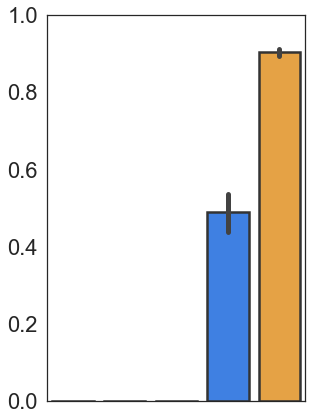

In [15]:
measure = "rSquared"
fig, ax = plt.subplots(1,1,figsize=(4.5,6))
sns.barplot(x="Model", y=measure,
            edgecolor=".2", linewidth=2.5, errwidth=5,
            palette=modelPalette,
            order=["Exponential", "vonBertalanffy", "Gompertz", "Logistic", "GeneralisedLogistic"],
            data=modelPredictionDf_comp[modelPredictionDf_comp.CellLine==cellLine], ax=ax)
ax.set_ylim(0,1)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
plt.tight_layout()
plt.savefig("./figures/predictions_growth_hd_%s.pdf"%(cellLine))